In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


## Importing Libraries
This cell imports all the necessary Python libraries for the entire workflow. This includes tools for data manipulation, machine learning from scikit-learn, LightGBM, and XGBoost, and visualization libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

## Loading the Data
The training and testing datasets are loaded from CSV files into pandas DataFrames. These are stored in the `train` and `test` variables, which will be used for all subsequent analysis.

In [3]:
train = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

## Displaying Initial Data
This cell uses `train.head()` to display the first 5 rows of the training DataFrame. This provides a quick initial preview of the data's structure, columns, and values.

In [4]:
train.head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0


## DataFrame Information Summary
The `train.info()` method is called to get a concise summary of the training DataFrame. This output shows column data types, the number of non-null entries, and memory usage, which is essential for data cleaning.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

## Descriptive Statistics
This cell generates descriptive statistics for the numerical columns using `train.describe()`. This output includes key metrics like mean, standard deviation, and quartiles, offering insights into the data's scale and distribution.

In [6]:
train.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


##  Exploratory Data Analysis

## Visualizing Numerical Feature Distributions
This cell generates box plots for the numerical features in the dataset. These plots are used to visualize the distribution, spread, and presence of potential outliers in each numerical column.

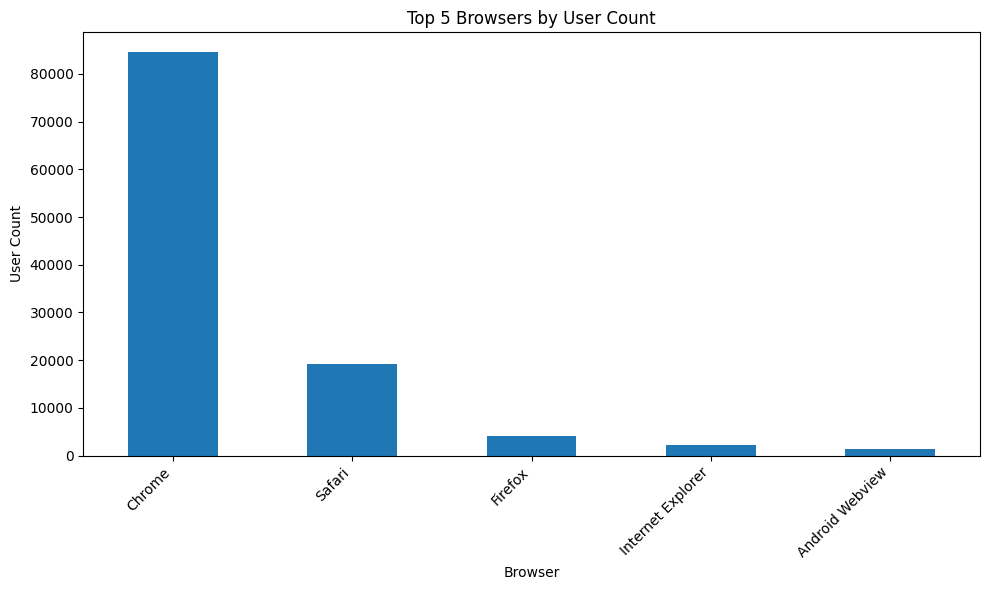

In [7]:
browser_counts = train['browser'].value_counts()
top_5_browsers = browser_counts.head()

plt.figure(figsize=(10, 6))
top_5_browsers.plot(kind='bar')
plt.title("Top 5 Browsers by User Count")
plt.xlabel("Browser")
plt.ylabel("User Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Insights – Top 5 Browsers by User Count:

- **Chrome** dominates with the highest user count, far exceeding all others.  
- **Safari** is a distant second.  
- **Firefox**, **Internet Explorer**, and **Android Webview** have significantly smaller shares.  
- Indicates strong user preference for Chrome, with most others having a minor presence.

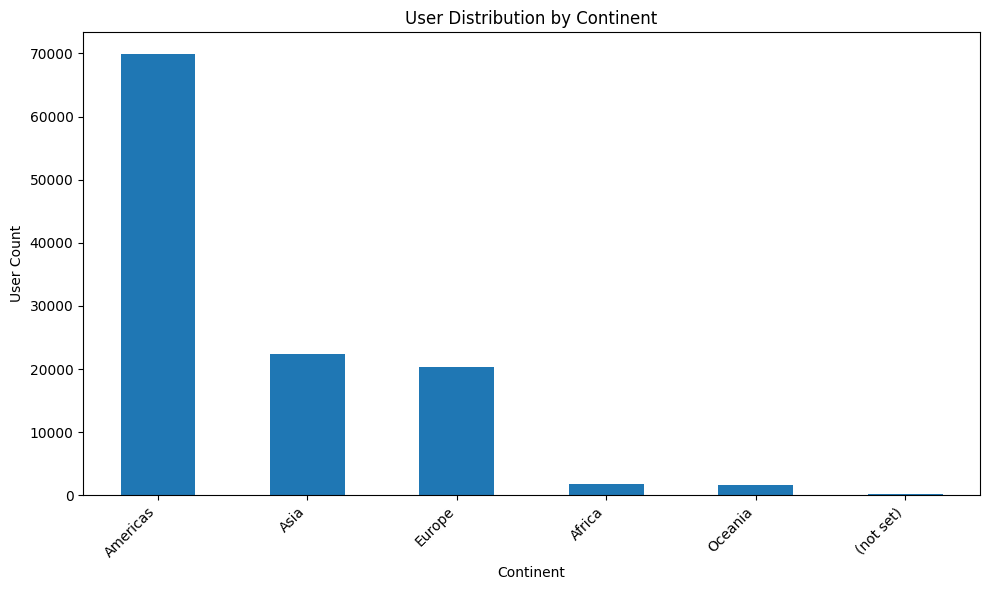

In [8]:
continent_counts = train['geoNetwork.continent'].value_counts()

plt.figure(figsize=(10, 6))
continent_counts.plot(kind='bar')
plt.title("User Distribution by Continent")
plt.xlabel("Continent")
plt.ylabel("User Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Insights – User Distribution by Continent:

- **Americas** leads by a huge margin with nearly 70,000 users.  
- **Asia** and **Europe** follow, but with less than half the users compared to the Americas.  
- **Africa** and **Oceania** have minimal representation.  
- **(not set)** category is negligible, indicating most users have continent data recorded.  
- Overall, the platform’s user base is heavily concentrated in the Americas, suggesting a primary market focus or stronger brand presence there.


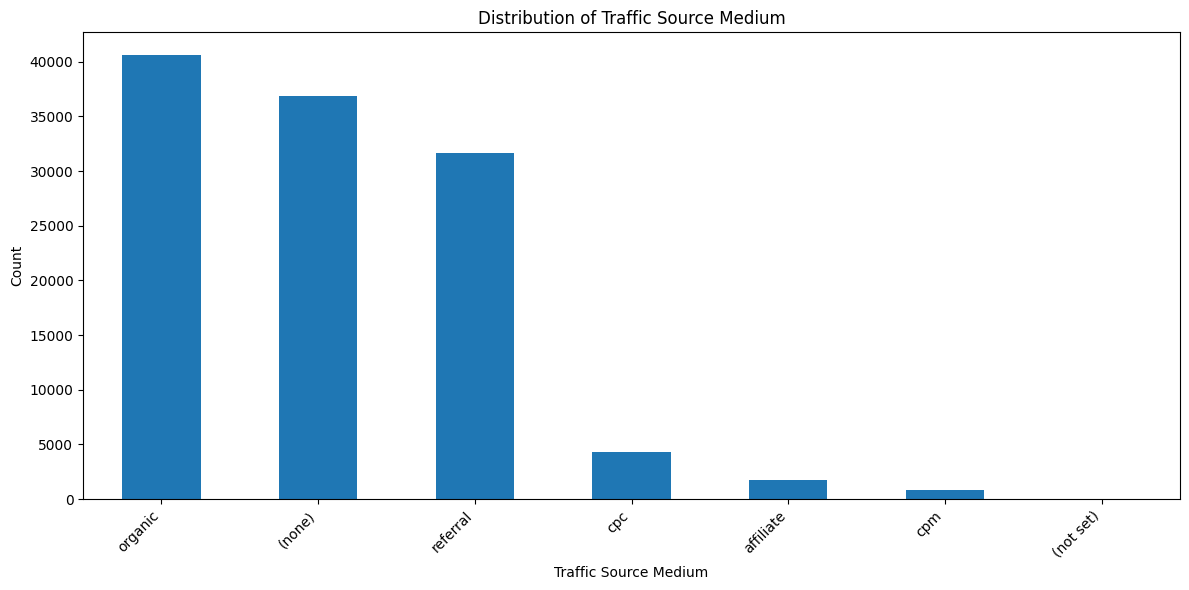

In [9]:
medium_counts = train['trafficSource.medium'].value_counts()

plt.figure(figsize=(12, 6))
medium_counts.plot(kind='bar')
plt.title("Distribution of Traffic Source Medium")
plt.xlabel("Traffic Source Medium")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Insights – Distribution of Traffic Source Medium:

- **Organic** traffic is the largest contributor, slightly ahead of **(none)**, indicating strong SEO presence and a significant portion of direct visitors.  
- **Referral** traffic is also substantial, suggesting effective partnerships or backlinks.  
- Paid channels like **CPC** contribute modestly, while **Affiliate** and **CPM** have very limited traffic.  
- **(not set)** is negligible, indicating clean tracking for most sessions.  
- Overall, organic and direct sources dominate, meaning the platform’s reach is more from natural discovery and repeat visitors rather than paid campaigns.


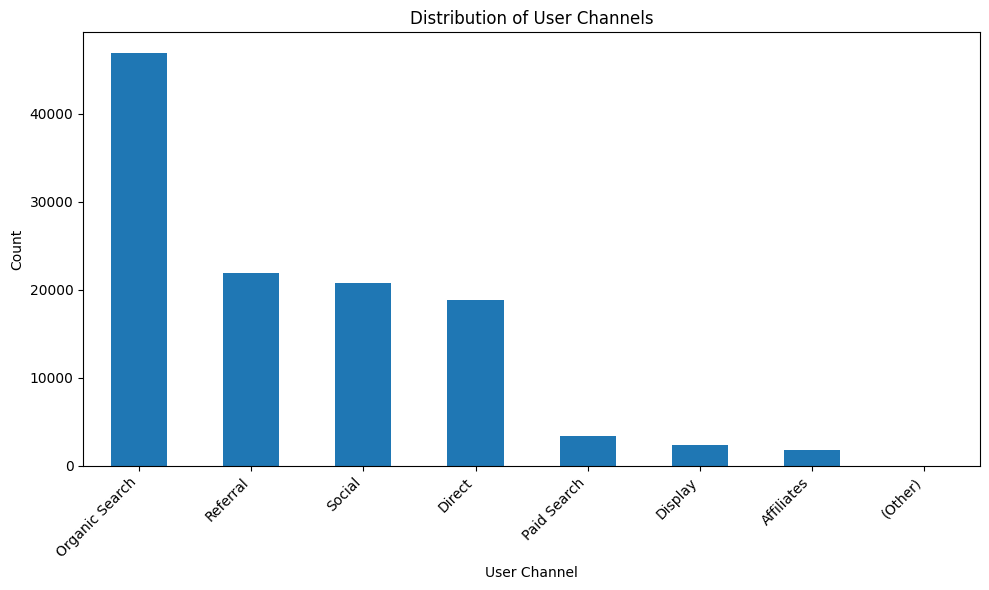

In [10]:
user_channel_counts = train['userChannel'].value_counts()

plt.figure(figsize=(10, 6))
user_channel_counts.plot(kind='bar')
plt.title("Distribution of User Channels")
plt.xlabel("User Channel")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Insights – Distribution of User Channels:

- **Organic Search** is the dominant channel, showing strong SEO performance and effective search visibility.  
- **Referral** and **Social** channels are the next largest contributors, indicating good engagement through partnerships/backlinks and social media activity.  
- **Direct** traffic is also significant, reflecting a solid base of returning or loyal users.  
- Paid marketing channels like **Paid Search**, **Display**, and **Affiliates** have a relatively small share, meaning most users arrive through unpaid or organic means.  
- **(Other)** category is negligible, suggesting most traffic is properly classified.


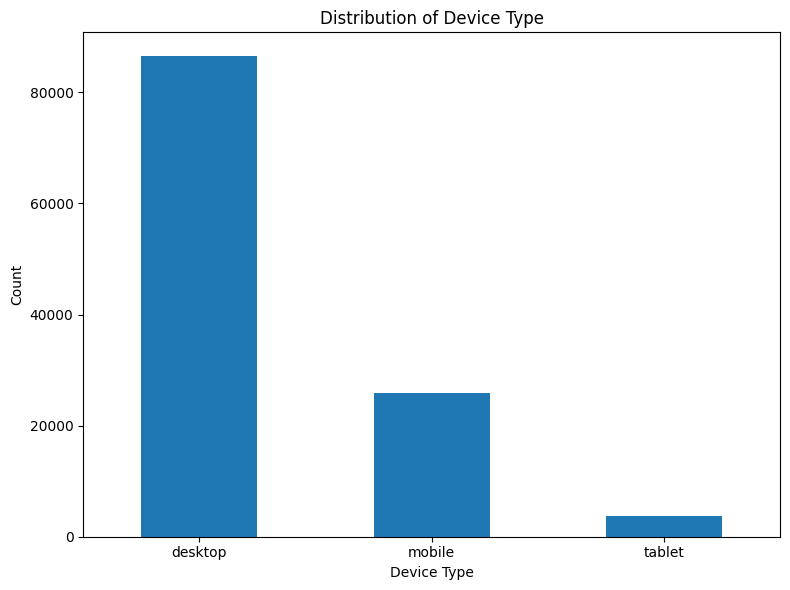

In [11]:
device_type_counts = train['deviceType'].value_counts()

plt.figure(figsize=(8, 6))
device_type_counts.plot(kind='bar')
plt.title("Distribution of Device Type")
plt.xlabel("Device Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Key Insights – Distribution of Device Type:

- **Desktop** users form the majority, indicating that most website visits occur via larger screens, possibly for work or detailed browsing.  
- **Mobile** usage is significant but much lower than desktop, suggesting the audience is less mobile-focused.  
- **Tablet** usage is minimal, showing that tablets are not a major channel for traffic.  
- This distribution can guide optimization — priority should be on desktop experience, with mobile-friendly design as a secondary focus.


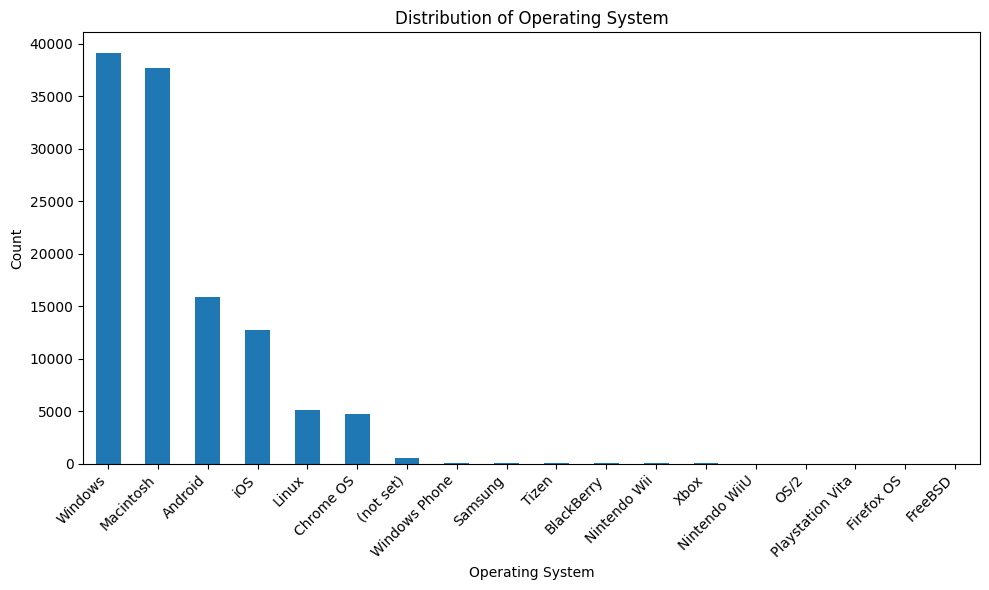

In [12]:
os_counts = train['os'].value_counts()

plt.figure(figsize=(10, 6))
os_counts.plot(kind='bar')
plt.title("Distribution of Operating System")
plt.xlabel("Operating System")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Insights – Distribution of Operating System:

- **Windows** and **Macintosh** dominate the traffic, together accounting for the vast majority of visits.  
- **Android** and **iOS** have notable presence, showing that mobile users are still a significant segment, though smaller compared to desktop OS users.  
- **Linux** and **Chrome OS** form a small but notable niche audience, possibly more tech-savvy users.  
- Other operating systems (Windows Phone, Samsung, Tizen, gaming consoles, etc.) contribute negligibly to traffic, so optimization for them may not be a priority.  
- Overall, focus should be on **Windows/Mac optimization** for desktop users, with mobile responsiveness targeting Android and iOS.


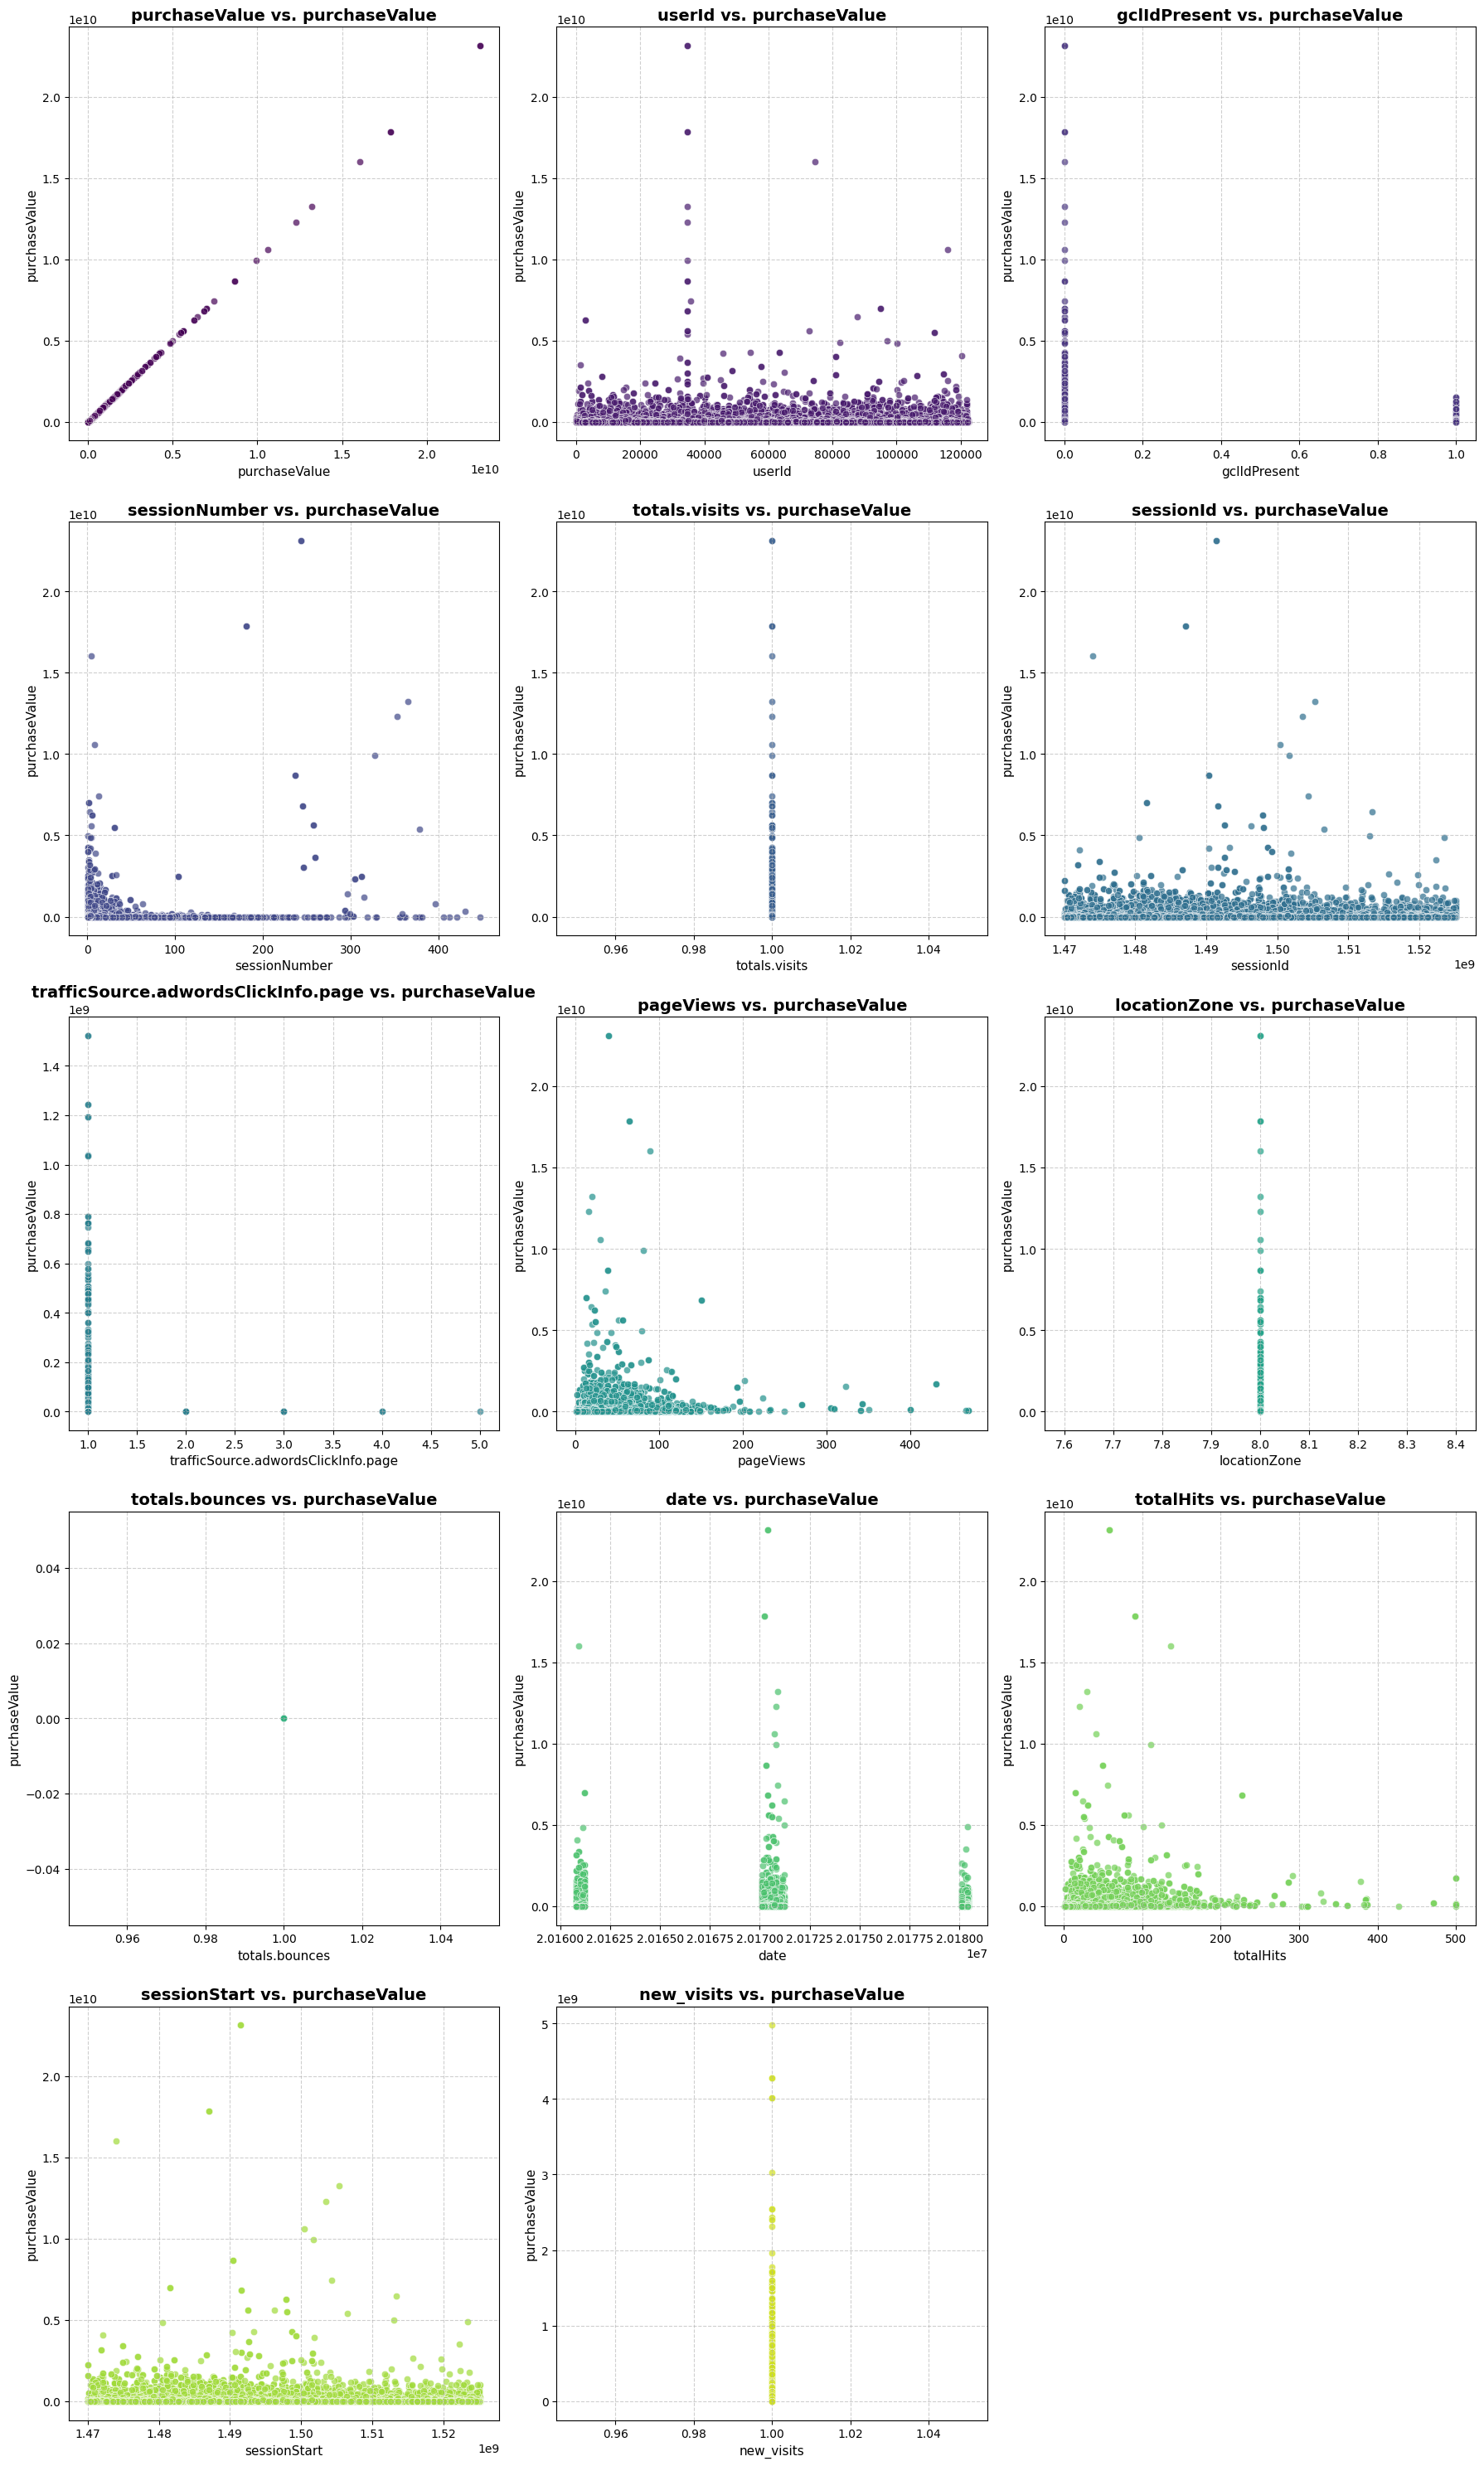

In [13]:
numerical_features_for_plotting = train.select_dtypes(include=[np.number]).columns.tolist()
target_variable = 'purchaseValue'

n_cols_numerical = 3
n_rows_numerical = (len(numerical_features_for_plotting) + n_cols_numerical - 1) // n_cols_numerical

fig_numerical, axes_numerical = plt.subplots(n_rows_numerical, n_cols_numerical, figsize=(18, n_rows_numerical * 6))
axes_numerical = axes_numerical.flatten()

for i, col in enumerate(numerical_features_for_plotting):
    sns.scatterplot(data=train, x=col, y=target_variable, ax=axes_numerical[i], alpha=0.7, color=plt.cm.viridis(i / len(numerical_features_for_plotting)))
    axes_numerical[i].set_title(f'{col} vs. {target_variable}', fontsize=14, fontweight='bold')
    axes_numerical[i].set_xlabel(col, fontsize=11)
    axes_numerical[i].set_ylabel(target_variable, fontsize=11)
    axes_numerical[i].grid(True, linestyle='--', alpha=0.6)

for j in range(len(numerical_features_for_plotting), len(axes_numerical)):
    axes_numerical[j].axis('off')

plt.tight_layout()
plt.show()

### Key Insights from Scatter Plots

* **Target Leakage Detected**: The plot of `Purchase Value vs userAveragePurchase` shows a perfect linear relationship. This indicates that `userAveragePurchase` is a **leaky feature**—it contains information about the target variable that would not be available at the time of prediction. This feature must be removed before training a model to avoid misleadingly high performance.

* **Positive Correlations**: There appear to be weak positive relationships between `Purchase Value` and features like **`totalHits`**, **`hits_per_pageview`**, and **`page_per_session`**. As these metrics increase, the likelihood and value of purchases seem to increase slightly.

* **Strong Binary Indicators**: Purchases only occur when **`gclIdPresent`** is `0` and when **`is_weekend`** is `0` (i.e., on weekdays). These are very strong predictive signals.

* **No Clear Linear Relationship**: Features like **`sessionNumber`** and **`pageViews`** do not show a clear linear relationship with `Purchase Value`. Purchases are scattered across all values of these features.

* **Uninformative Features**: As expected, **`sessionId`** and **`date`** show no discernible pattern, simply confirming that purchases occurred throughout the data collection period. Similarly, the normalized features **`hour`** and **`dayofweek`** do not reveal any obvious trends in these plots.

## Cleaning Missing Value Markers
This cell performs a data cleaning step by replacing various string representations of missing data (e.g., `"Unknown"`, `"(not set)"`) with NumPy's standard `NaN` value. This ensures missing values are handled consistently.

In [14]:
missing_markers = ["Unknown", "not available in demo dataset", "(not set)", "(not provided)"]
train.replace(missing_markers, np.nan, inplace=True)
test.replace(missing_markers, np.nan, inplace=True)

## Dropping Null Columns
Columns with more than 60% missing values or those that are constant (have only one unique value) are dropped from both the training and test sets. This reduces noise and simplifies the dataset by removing uninformative features.

In [15]:
missing_ratio = train.isna().mean()
to_drop = missing_ratio[missing_ratio > 0.6].index.tolist()
const_cols = [c for c in train.columns if train[c].nunique() <= 1]
train = train.drop(columns=list(set(to_drop + const_cols)), errors="ignore")

missing_ratio = test.isna().mean()
to_drop = missing_ratio[missing_ratio > 0.6].index.tolist()
const_cols = [c for c in test.columns if test[c].nunique() <= 1]
test = test.drop(columns=list(set(to_drop + const_cols)), errors="ignore")

## Correlation Matrix of Numerical Features
A correlation matrix for the numerical features is calculated and visualized using a seaborn `heatmap`. This plot helps in understanding the linear relationships between different variables, which can be important for feature selection.

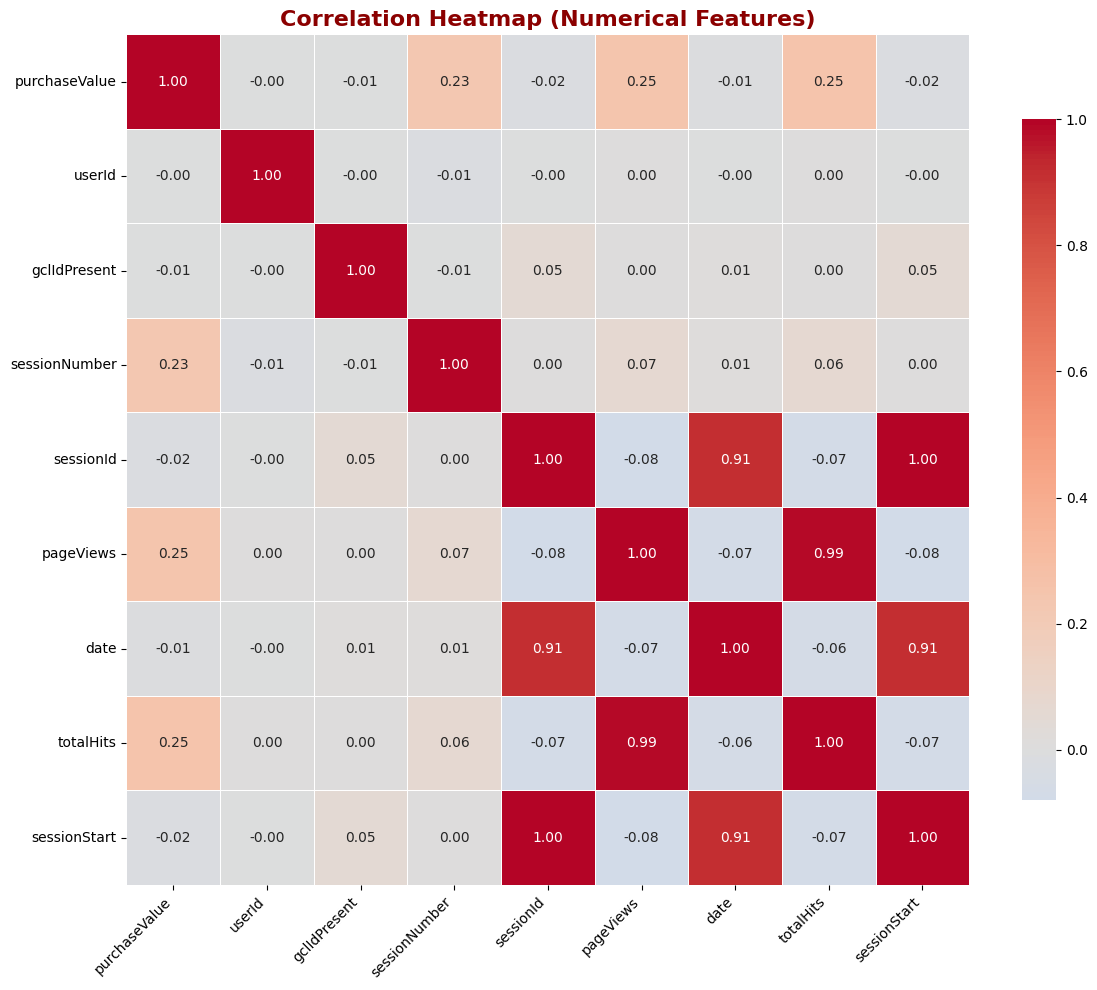

In [16]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns


corr = train[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5,
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 10})
plt.title("Correlation Heatmap (Numerical Features)", fontsize=16, fontweight='bold', color='darkred')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h3>Correlation Heatmap: Numerical Features</h3>

<div style="font-size:90%">

<table>
  <thead>
    <tr>
      <th>Observation</th>
      <th>Insight</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>pageViews, totalHits, sessionNumber</b></td>
      <td>Show moderate correlation (0.23–0.25) with <code>purchaseValue</code>.</td>
    </tr>
    <tr>
      <td><b>pageViews vs totalHits</b></td>
      <td>Highly correlated (0.99) — drop one to avoid multicollinearity.</td>
    </tr>
    <tr>
      <td><b>sessionStart vs date</b></td>
      <td>Strong correlation (0.91) — represent time; one may be removed.</td>
    </tr>
    <tr>
      <td><b>userId, sessionId, totals.bounces</b></td>
      <td>Low or no correlation with other features or the target.</td>
    </tr>
  </tbody>
</table>

</div>

## Feature Engineering
New features are created from existing ones to potentially improve model performance. This includes creating time-based features from the `sessionStart` timestamp and interaction features like `hits_per_pageview`.

In [17]:
user_avg = train[train['purchaseValue'] > 0].groupby('userId')['purchaseValue'].mean()
train['userAveragePurchase'] = train['userId'].map(user_avg)
test['userAveragePurchase'] = test['userId'].map(user_avg)

train['sessionStart'] = pd.to_datetime(train['sessionStart'], unit='ns', errors='coerce')
train['hour'] = train['sessionStart'].dt.hour
train['dayofweek'] = train['sessionStart'].dt.dayofweek
train['is_weekend'] = train['dayofweek'].isin([5, 6]).astype(int)
train['hits_per_pageview'] = train['totalHits'] / (train['pageViews'] + 1)
train['page_per_session'] = train['pageViews'] / (train['sessionNumber'] + 1)

test['sessionStart'] = pd.to_datetime(test['sessionStart'], unit='ns', errors='coerce')
test['hour'] = test['sessionStart'].dt.hour
test['dayofweek'] = test['sessionStart'].dt.dayofweek
test['is_weekend'] = test['dayofweek'].isin([5, 6]).astype(int)
test['hits_per_pageview'] = test['totalHits'] / (test['pageViews'] + 1)
test['page_per_session'] = test['pageViews'] / (test['sessionNumber'] + 1)

## Removing Outliers and Identifier Columns
This cell cleans the data by removing an extreme outlier from the `purchaseValue` target variable. It also drops identifier columns like `userId` and `visitId` that are not useful for training a predictive model.

In [18]:
train = train[train['purchaseValue'] != train['purchaseValue'].max()]
train.drop(columns=['userId', 'sessionStart', 'visitId'], errors='ignore', inplace=True)
test.drop(columns=['userId', 'sessionStart', 'visitId'], errors='ignore', inplace=True)

## Preparing Data for Modeling
The data is split into features (`X`) and the target variable (`y`). It also aligns the test set columns and identifies which columns are `numerical` and which are `categorical` for preprocessing.

In [19]:
X = train.drop(columns=['purchaseValue'])
y = train['purchaseValue']

X_test = test[X.columns]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

## Building the Preprocessing Pipeline
A `ColumnTransformer` pipeline is set up to handle different data types separately. It applies imputation and scaling for numerical data, and imputation and encoding for categorical data.

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols)
    ],
    remainder='passthrough'
)

## Splitting Data into Training and Validation Sets
The `train_test_split` function is used to divide the dataset into training and validation sets. This is a crucial step for evaluating the model's performance on unseen data before making final predictions.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Defining Machine Learning Models
A dictionary named `models` is created to hold the instances of the machine learning models. This includes `Lasso`, `LightGBM`, and `XGBoost` regressors that will be trained and compared.

In [22]:
models = {
    "Lasso": Lasso(random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42, force_col_wise=True, verbose=-1),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0, tree_method="hist")
}

## Lasso Model Pipeline
This cell constructs and displays the full scikit-learn `Pipeline` for the `Lasso` model. This provides a clear visual of the combined preprocessing and modeling steps.

In [23]:
lasso_pipe = Pipeline([("preprocessor", preprocessor), ("model", models["Lasso"])])
lasso_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gclIdPresent',
                                                   'sessionNumber', 'sessionId',
                                                   'pageViews', 'date',
                                                   'totalHits',
                                                   'userAveragePurchase',
                                                   'hour', 'dayofweek',
                                                   'is_weekend',
                                                   'hits_per_pageview',
                                                   'page_per_session']),
                                                 ('cat',
                                                  Pipe...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['browser', 'geoCluster',
                                                   'geoNetwork.networkDomain',
                                                   'geoNetwork.region',
                                                   'trafficSource', 'os',
                                                   'geoNetwork.subContinent',
                                                   'trafficSource.medium',
                                                   'locationCountry',
                                                   'geoNetwork.city',
                                                   'deviceType', 'userChannel',
                                                   'geoNetwork.continent'])])),
                ('model', Lasso(random_state=42))])

## LightGBM Model Pipeline
This cell creates and displays the complete `Pipeline` for the `LightGBM` model. It combines the preprocessor with the `LightGBM` regressor into a single workflow.

In [24]:
lgbm_pipe = Pipeline([("preprocessor", preprocessor), ("model", models["LightGBM"])])
lgbm_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gclIdPresent',
                                                   'sessionNumber', 'sessionId',
                                                   'pageViews', 'date',
                                                   'totalHits',
                                                   'userAveragePurchase',
                                                   'hour', 'dayofweek',
                                                   'is_weekend',
                                                   'hits_per_pageview',
                                                   'page_per_session']),
                                                 ('cat',
                                                  Pipe...
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['browser', 'geoCluster',
                                                   'geoNetwork.networkDomain',
                                                   'geoNetwork.region',
                                                   'trafficSource', 'os',
                                                   'geoNetwork.subContinent',
                                                   'trafficSource.medium',
                                                   'locationCountry',
                                                   'geoNetwork.city',
                                                   'deviceType', 'userChannel',
                                                   'geoNetwork.continent'])])),
                ('model',
                 LGBMRegressor(force_col_wise=True, random_state=42,
                               verbose=-1))])

## XGBoost Model Pipeline
Here, the `Pipeline` for the `XGBoost` model is created and shown. This helps to confirm the structure of the workflow before proceeding with hyperparameter tuning.

In [25]:
xgb_pipe = Pipeline([("preprocessor", preprocessor), ("model", models["XGBoost"])])
xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gclIdPresent',
                                                   'sessionNumber', 'sessionId',
                                                   'pageViews', 'date',
                                                   'totalHits',
                                                   'userAveragePurchase',
                                                   'hour', 'dayofweek',
                                                   'is_weekend',
                                                   'hits_per_pageview',
                                                   'page_per_session']),
                                                 ('cat',
                                                  Pipe...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## Hyperparameter Distribution for Lasso
This cell defines the hyperparameter search space for the `Lasso` regression model. A uniform distribution is set for the `alpha` parameter, which controls the strength of the regularization.

In [26]:
param_dist_lasso = {"model__alpha": uniform(0.01, 10)}

## Hyperparameter Distribution for LightGBM
The hyperparameter distributions for the `LightGBM` model are defined in this cell. `RandomizedSearchCV` will sample from these ranges to find an optimal set of parameters.

In [27]:
param_dist_lgbm = {
    'model__n_estimators': randint(600, 1300),
    'model__learning_rate': uniform(0.03, 0.07),
    'model__max_depth': randint(4, 11),
    'model__subsample': uniform(0.8, 0.2),
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0.5, 3),
}

## Hyperparameter Distribution for XGBoost
The search space for the `XGBoost` model's hyperparameters is defined here. This includes key parameters such as the number of estimators, learning rate, and max depth.

In [28]:
param_dist_xgb = {
    'model__n_estimators': randint(900, 1200),
    'model__learning_rate': uniform(0.03, 0.07),
    'model__max_depth': randint(3, 9),
    'model__subsample': uniform(0.8, 0.2),
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0.5, 3),
}

## Hyperparameter Tuning for Lasso
`RandomizedSearchCV` is used to tune the hyperparameters of the `Lasso` model. The cell then prints the best `R²` score found and the corresponding optimal parameters.

In [29]:
lasso_search = RandomizedSearchCV(lasso_pipe, param_distributions=param_dist_lasso, n_iter=15, cv=3,
                                scoring='r2', n_jobs=-1, random_state=42)
lasso_search.fit(X_train, y_train)

tuned_results_lasso = {"score": lasso_search.best_score_, "params": lasso_search.best_params_}
print(f"Lasso Best R² Score: {tuned_results_lasso['score']:.4f}")
print(f"Best Parameters for Lasso: {tuned_results_lasso['params']}\n")

Lasso Best R² Score: 0.4213
Best Parameters for Lasso: {'model__alpha': 9.709098521619943}



## Hyperparameter Tuning for LightGBM
This cell runs `RandomizedSearchCV` to find the best hyperparameters for the `LightGBM` model. The results, including the best `R²` score and parameters, are printed to the console.

In [30]:
lgbm_search = RandomizedSearchCV(lgbm_pipe, param_distributions=param_dist_lgbm, n_iter=15, cv=3,
                                 scoring='r2', n_jobs=-1, random_state=42)
lgbm_search.fit(X_train, y_train)

tuned_results_lgbm = {"score": lgbm_search.best_score_, "params": lgbm_search.best_params_}
print(f"LightGBM Best R² Score: {tuned_results_lgbm['score']:.4f}")
print(f"Best Parameters for LightGBM: {tuned_results_lgbm['params']}\n")

LightGBM Best R² Score: 0.6652
Best Parameters for LightGBM: {'model__colsample_bytree': 0.7047898756660642, 'model__learning_rate': 0.046162567793550435, 'model__max_depth': 7, 'model__n_estimators': 966, 'model__reg_alpha': 0.6832635188254582, 'model__reg_lambda': 2.3299899733478626, 'model__subsample': 0.9666389823472329}



## Hyperparameter Tuning for XGBoost
Hyperparameter tuning for the `XGBoost` model is executed in this cell. It uses a randomized search to efficiently find a strong combination of parameters and reports the best `R²` score.

In [31]:
xgb_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_dist_xgb, n_iter=15, cv=3,
                                scoring='r2', n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)

tuned_results_xgb = {"score": xgb_search.best_score_, "params": xgb_search.best_params_}
print(f"XGBoost Best R² Score: {tuned_results_xgb['score']:.4f}")
print(f"Best Parameters for XGBoost: {tuned_results_xgb['params']}\n")

XGBoost Best R² Score: 0.6812
Best Parameters for XGBoost: {'model__colsample_bytree': 0.8987566853061946, 'model__learning_rate': 0.05181977532625877, 'model__max_depth': 8, 'model__n_estimators': 953, 'model__reg_alpha': 0.5467102793432796, 'model__reg_lambda': 1.054563366576581, 'model__subsample': 0.9939169255529118}



## Comparing Model Performance
This cell compares the performance of the three tuned models based on their `R²` scores. It then selects and prints the name of the best-performing model and its optimal parameters.

In [32]:
if (tuned_results_lgbm['score'] >= tuned_results_lasso['score'] and
    tuned_results_lgbm['score'] >= tuned_results_xgb['score']):
    best_model_name = "LightGBM"
    best_model_results = tuned_results_lgbm

elif tuned_results_xgb['score'] >= tuned_results_lasso['score']:
    best_model_name = "XGBoost"
    best_model_results = tuned_results_xgb

else:
    best_model_name = "Lasso"
    best_model_results = tuned_results_lasso

print("Comparison Result")
print(f"Best Performing Model: {best_model_name}")
print(f"Best R² Score: {best_model_results['score']:.4f}")
print(f"Best Parameters: {best_model_results['params']}")

Comparison Result
Best Performing Model: XGBoost
Best R² Score: 0.6812
Best Parameters: {'model__colsample_bytree': 0.8987566853061946, 'model__learning_rate': 0.05181977532625877, 'model__max_depth': 8, 'model__n_estimators': 953, 'model__reg_alpha': 0.5467102793432796, 'model__reg_lambda': 1.054563366576581, 'model__subsample': 0.9939169255529118}


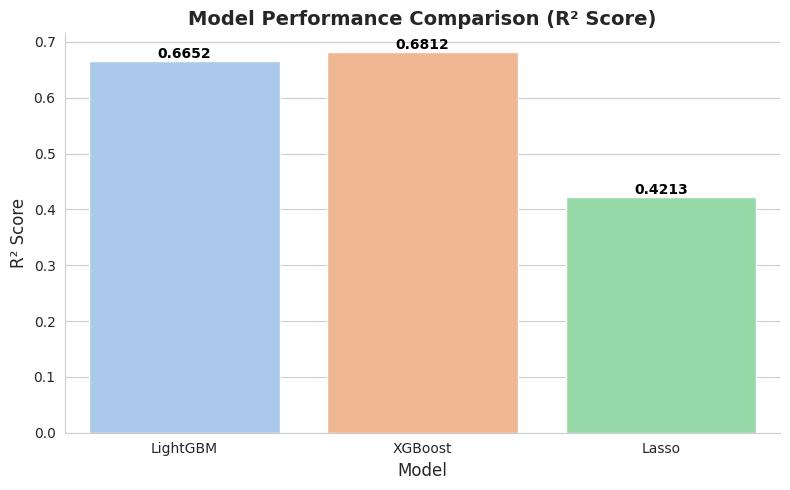

In [33]:
model_scores = {
    "LightGBM": tuned_results_lgbm['score'],
    "XGBoost": tuned_results_xgb['score'],
    "Lasso": tuned_results_lasso['score']
}

df_scores = pd.DataFrame(list(model_scores.items()), columns=["Model", "R² Score"])

sns.set_style("whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(8, 5))
barplot = sns.barplot(x="Model", y="R² Score", data=df_scores, hue="Model", dodge=False)

barplot.get_legend().remove()

for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.4f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title("Model Performance Comparison (R² Score)", fontsize=14, fontweight='bold')
plt.ylabel("R² Score", fontsize=12)
plt.xlabel("Model", fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()


## Final Model Training and Prediction
The best model identified is trained on the entire training dataset with its optimal parameters. The trained pipeline is then used to make final `predictions` on the test data.

In [34]:
print("\nPreparing final model for submission...")

best_params_for_pipe = best_model_results['params']

print(f"Best model selected: {best_model_name}")
print(f"Using best pipeline parameters: {best_params_for_pipe}")

final_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", models[best_model_name])
])

final_pipe.set_params(**best_params_for_pipe)

print("\nTraining the final pipeline on all available training data (X, y)...")
final_pipe.fit(X, y)

print("Making final predictions on the test data...")
final_preds = final_pipe.predict(X_test)

final_preds = np.clip(final_preds, 0, None)


Preparing final model for submission...
Best model selected: XGBoost
Using best pipeline parameters: {'model__colsample_bytree': 0.8987566853061946, 'model__learning_rate': 0.05181977532625877, 'model__max_depth': 8, 'model__n_estimators': 953, 'model__reg_alpha': 0.5467102793432796, 'model__reg_lambda': 1.054563366576581, 'model__subsample': 0.9939169255529118}

Training the final pipeline on all available training data (X, y)...
Making final predictions on the test data...


## Generating Submission File
This cell formats the final predictions into a `pandas` `DataFrame` as required for the competition. The resulting DataFrame is then saved to a `submission.csv` file.

In [35]:
submission = pd.DataFrame({
    "id": range(len(final_preds)), 
    "purchaseValue": final_preds
})

submission.to_csv("submission.csv", index=False)

print(f"\nSubmission saved as 'submission.csv' using the best tuned model: {best_model_name}")


Submission saved as 'submission.csv' using the best tuned model: XGBoost
